In [2]:
import msiwarp as mx

from msiwarp.util.read_sbd import read_sbd_meta, read_spectrum_fs
from msiwarp.util.warp import to_mz, peak_density_mz, plot_range, get_mx_spectrum, generate_mean_spectrum

import matplotlib.pyplot as plt
import numpy as np

In [30]:
# scaling to test impact of sigma on alignment performance
sigma_1 = 2e-5
epsilon = 2.55

fdir = 'datasets/tof-spheroids/'

fpath_sbd = fdir + 'spheroids-no_normalization.sbd'
fpath_triplets_raw = fdir + 'triplets_raw.dat'
fpath_triplets_warped = fdir + 'triplets_warped.dat'
fpath_dispersion_csv = fdir + 'results/dispersion_50.csv'
fpath_scatter = fdir + 'results/scatter'

# experiment settings
instrument_type = 'tof'
mz_begin = 800
mz_end = 3000

meta = read_sbd_meta(fpath_sbd)
spectra = [get_mx_spectrum(fpath_sbd, meta, i, sigma_1, instrument_type) for i in range(len(meta))]
tic = np.array([m[2] for m in meta])
i_r = np.argmax(tic)

print("using spectrum {} as reference, sigma: {} ppm, and epsilon: {:0.2f} ppm".format(i_r, sigma_1 * 1e6, 2 * epsilon * sigma_1 * 1e6))

using spectrum 977 as reference, sigma: 50.0 ppm, and epsilon: 255.00 ppm


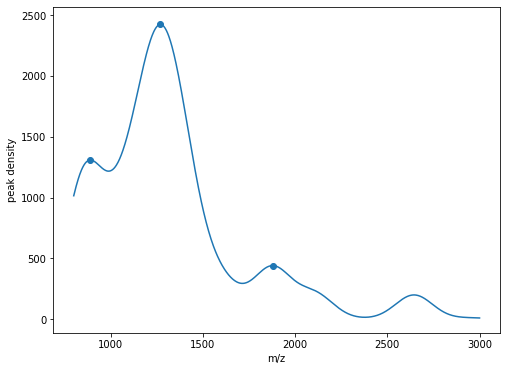

In [51]:
xi = np.linspace(mz_begin, mz_end, 1000)
(yi, xp, yp) = peak_density_mz(spectra, xi, bandwidth=100, stride=10)

_, ax = plt.subplots(figsize=(8,6))
ax.plot(xi, yi)
ax.scatter(xp, yp)
ax.set_ylabel('peak density')
ax.set_xlabel('m/z')
plt.show()

# we're using the same warping nodes for all spectra here
node_mzs = (xp[:-1] + xp[1:]) / 2
node_mzs = np.array([mz_begin, *node_mzs, mz_end])

# setup warping parameters 
n_steps = 50 # the slack of a warping node is +- (n_steps * s * sigma @ the node's m/z)
s = 2 * epsilon / n_steps 

node_deltas = np.array([s * sigma_1 * mz  for mz in node_mzs])
nodes = mx.initialize_nodes(node_mzs, node_deltas, n_steps)

In [52]:
s_r = get_mx_spectrum(fpath_sbd, meta, i_r, sigma_1, instrument_type)

print("warping spectra...")

import time
t0 = time.time()
optimal_moves = mx.find_optimal_spectra_warpings(spectra, s_r, nodes, epsilon)
t1 = time.time()
print("found optimal warpings in {:0.2f}s".format(t1 - t0))

t2 = time.time()
warped_spectra = [mx.warp_peaks(s_i, nodes, o_i) for (s_i, o_i) in zip(spectra, optimal_moves)]
t3 = time.time()
print("warped spectra in {:0.2f}s".format(t3 - t2))

warping spectra...
found optimal warpings in 2.41s
warped spectra in 0.07s


In [53]:
if mx.spectra_to_triplets(fpath_triplets_raw, spectra):
    print("wrote raw triplets to file")

if mx.spectra_to_triplets(fpath_triplets_warped, warped_spectra):
    print("wrote warped triplets to file")

wrote raw triplets to file
wrote warped triplets to file


In [58]:
n_points = 1000000

s_m = generate_mean_spectrum(spectra, n_points, sigma_1,
                             mz_begin, mz_end, tic, instrument_type)

s_m_100 = mx.peaks_top_n(s_m, 50)
mz_ref = np.sort(to_mz(s_m_100))

generating mean spectrum with 105742 sampling points...
generated mean spectrum


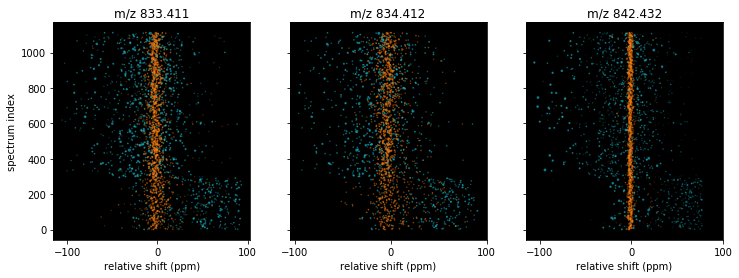

In [60]:
mass_tolerance = 100 # ppm
    
fig, ax = plt.subplots(1, 3, figsize=(12,4), sharey=True)

ax[0].set_ylabel('spectrum index')

for i, mz_i in enumerate(mz_ref[:3]):
    d = mass_tolerance * mz_i / 1e6 # -+ mass_tolerance around reference mass 
    mz0 = mz_i - d
    mz1 = mz_i + d    
    
    plot_range(fpath_triplets_raw, mz0, mz1, ax[i], 'tab:cyan', 5, in_ppm=True)
    plot_range(fpath_triplets_warped, mz0, mz1, ax[i], 'tab:orange', 5, in_ppm=True)
    
    ax[i].set_facecolor((0.0, 0.0, 0.0))
    ax[i].set_title('m/z {:0.3f}'.format(mz_i))
    ax[i].set_xticks([-mass_tolerance, 0, mass_tolerance])
    ax[i].set_xlabel('relative shift (ppm)')

using existing scatter plot output directory


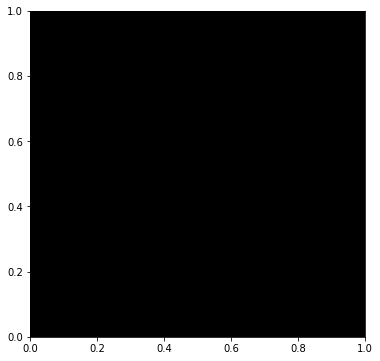

In [64]:
import os

if not os.path.exists(fpath_scatter):    
    os.makedirs(fpath_scatter)
    print("made scatter plot output directory")
else:
    print("using existing scatter plot output directory")
    
fig, ax = plt.subplots(figsize=(6,6))
for i, mz_i in enumerate(mz_ref):
    d = mass_tolerance * mz_i / 1e6 # -+ 350 ppm around reference mass 
    mz0 = mz_i - d
    mz1 = mz_i + d    
    
    plot_range(fpath_triplets_raw, mz0, mz1, ax, 'tab:cyan', 100, in_ppm=True)
    plot_range(fpath_triplets_warped, mz0, mz1, ax, 'tab:orange', 100, in_ppm=True)
    
    ax.set_facecolor((0.0, 0.0, 0.0))
    ax.set_title('m/z {:0.3f}'.format(mz_i))
    ax.set_xlim([-mass_tolerance, mass_tolerance])
    
    fig.savefig(fpath_scatter + '/mz_{}.png'.format(int(mz_i)), dpi=200)
    ax.cla()